In [1]:
# the idea beyind pinn is to used the pde  in calculating the loss!
# Data used for loss optimization is the BC, IC and domain points

In [2]:
# import libaries
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
from tqdm import tqdm

In [3]:
''' How to solve a PINN problem'''
#a) Define the NN
#b) Define the IC and BC
#c) Set Optimizers
#d) Define the Loss Function
#e) Run the training looop
#f) Results post processing

' How to solve a PINN problem'

Now lets solve the 1D Burger's equation using Pytorch!....

$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0
$

In [4]:
#1) Build the Neural Network for the 1D Burger's equation

class Burger_1D_NN(nn.Module):
    def __init__(self):
        super(Burger_1D_NN, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(2,20), # we start with two inputs: x and t and expand to 20 neurons
            nn.Tanh(), # activation function
            
            nn.Linear(20,30), 
            nn.Tanh(), 
            
            nn.Linear(30,30), 
            nn.Tanh(), 
            
            nn.Linear(30,20), 
            nn.Tanh(), 
            
            nn.Linear(20,20), 
            nn.Tanh(), 

            # layer 6
            nn.Linear(20,1)
        )

    # define forward pass
    def forward(self,x):
        out = self.features(x)
        return out

In [5]:
#2) Supply the input data

class Net:
    def __init__(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = Burger_1D_NN().to(device)
        # define step size in x and t
        self.dx = 0.1
        self.dt = 0.1

        x = torch.arange(-1,1+self.dx, self.dx)
        t = torch.arange(0,1+self.dt, self.dt)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        ## train data

        # boundary condition as you wish!
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

        # set initial condition as you wish

        ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T

        self.X_train = torch.cat([bc1,bc2,ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi*ic[:,0])

        self.y_train = torch.cat([y_bc1,y_bc2,y_ic])
        
        self.y_train = self.y_train.unsqueeze(1) # for shape consistency we have to unsqueeze

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # Optimizer setting
        self.adam = torch.optim.Adam(self.model.parameters())

        # limited-memory Broyden-Fletche-Goldfarb-Shanno (L-BFGS)
        self.optimizer  = torch.optim.LBFGS(
            self.model.parameters(),
            lr = 0.1,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad=1e-7,
            tolerance_change=1.0* np.finfo(float).eps,
            line_search_fn='strong_wolfe'
        )

        self.criterion = torch.nn.MSELoss()
        self.iter =1

    def loss_func(self):

        # LOSS related to the data
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # loss related to the data
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        # LOSS related to the PDE
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u, self.X, 
            grad_outputs=torch.ones_like(u),
            create_graph = True,
            retain_graph = True)[0]

        #print(du_dx)
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX, self.X, 
            grad_outputs=torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True)[0]
        
        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx, (0.01/math.pi)*du_dxx)

        loss = loss_pde + loss_data

        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            
        self.iter +=1

        return loss

    def train(self):
        self.model.train()

        # we use two optimizers
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [6]:

x = torch.arange(-1,1+0.1,0.1)
t = torch.arange(-1,1+0.1, 0.1)
X = torch.stack(torch.meshgrid(x,t))

/Users/stanleyakor/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
X.shape

torch.Size([2, 21, 21])

In [8]:
X_ = X.reshape(2,-1).T
print(X_.shape)

torch.Size([441, 2])


In [9]:
net =Net()
net.train()

100 0.12642958760261536
200 0.08177293837070465
300 0.0649765208363533
400 0.040063612163066864
500 0.020364657044410706
600 0.013212306424975395
700 0.011094668880105019
800 0.009671468287706375
900 0.009464417584240437
1000 0.008356588892638683
1100 0.0057894522324204445
1200 0.004129957407712936
1300 0.003118890803307295
1400 0.002308435505256057
1500 0.0016254070214927197
1600 0.0012149476679041982
1700 0.0009072068496607244
1800 0.0006993540446273983
1900 0.0005509585607796907
2000 0.0004659454571083188
2100 0.00035163541906513274
2200 0.0002913276257459074
2300 0.00024173589190468192
2400 0.00019598237122409046
2500 0.0001727058697724715
2600 0.0001456938625779003
2700 0.00011710209946613759
2800 0.00010884519724640995
2900 0.00010177669173572212
3000 8.711300324648619e-05
3100 7.98251130618155e-05
3200 7.498251216020435e-05
3300 6.942511390661821e-05
3400 6.363430293276906e-05
3500 6.008434502291493e-05
3600 5.780620995210484e-05
3700 5.500966653926298e-05
3800 5.302004137774929

In [10]:
net.model.eval()

Burger_1D_NN(
  (features): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [11]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [12]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [13]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

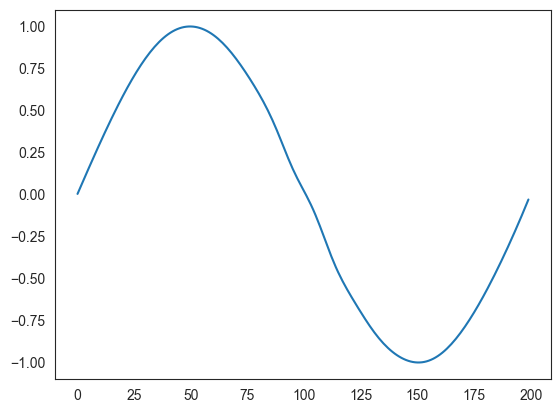

In [14]:
plt.plot(y_pred[:,0])